In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [3]:
import os
import numpy as np

# 数据文件
fname = os.path.join("/mnt/workspace/jena_climate_2009_2016.csv")
# 读取数据
with open(fname) as f:
    data = f.read()

# 按行分割数据
lines = data.split("\n")
# 提取表头和数据, 每个数据以逗号分隔
header = lines[0].split(",")
# 去掉第一行（表头）
lines = lines[1:]
print(header)
print('记录总数：', len(lines))

# 温度变量赋初值0
temperature = np.zeros((len(lines),)) 
# 全部数据赋初值0，行数为记录数，列数为表头数减1(去掉时间列)
raw_data = np.zeros((len(lines), len(header) - 1))
# 逐行处理数据
for i, line in enumerate(lines):
    # 逗号分隔数据，去掉第一列（时间）
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1] # 第2列为温度数据
    raw_data[i, :] = values[:] # 全部数据（没有表头行、没有时间列）

print('温度数据：', temperature)
print('全部数据：', raw_data)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
记录总数： 420551
温度数据： [-8.02 -8.41 -8.51 ... -3.16 -4.23 -4.82]
全部数据： [[ 9.9652e+02 -8.0200e+00  2.6540e+02 ...  1.0300e+00  1.7500e+00
   1.5230e+02]
 [ 9.9657e+02 -8.4100e+00  2.6501e+02 ...  7.2000e-01  1.5000e+00
   1.3610e+02]
 [ 9.9653e+02 -8.5100e+00  2.6491e+02 ...  1.9000e-01  6.3000e-01
   1.7160e+02]
 ...
 [ 9.9982e+02 -3.1600e+00  2.7001e+02 ...  1.0800e+00  2.0000e+00
   2.1520e+02]
 [ 9.9981e+02 -4.2300e+00  2.6894e+02 ...  1.4900e+00  2.1600e+00
   2.2580e+02]
 [ 9.9982e+02 -4.8200e+00  2.6836e+02 ...  1.2300e+00  1.9600e+00
   1.8490e+02]]


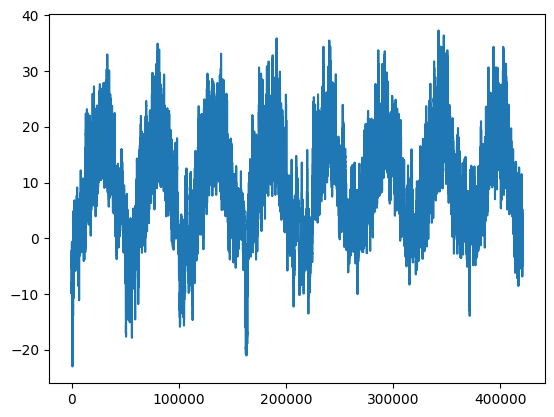

In [17]:
# 绘制8年全部温度数据
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

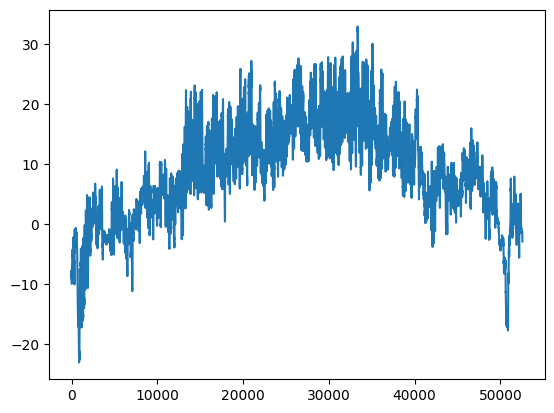

In [4]:
# 绘制前一年温度数据
hundred_days = 6*24*365
plt.plot(range(hundred_days), temperature[:hundred_days])

In [4]:
# ======= 准备数据 =========
# 训练数据量，占50%，210225个
num_train_samples = int(0.5 * len(raw_data))
# 验证数据量，占25%，105112个
num_val_samples = int(0.25 * len(raw_data))
# 测试数据量，剩下的25%，105114个
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

# 训练数据平均值（有的数据值大，有的数据值小，归一化）
mean = raw_data[:num_train_samples].mean(axis=0) # 按列求平均值
# 所有数据减去平均值
raw_data -= mean
# 训练数据标准差
std = raw_data[:num_train_samples].std(axis=0)
# 所有数据除以标准差
raw_data /= std

num_train_samples: 210275
num_val_samples: 105137
num_test_samples: 105139


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 采样频率=6：每6个数据点采样(保留)一个数据点，即每小时一个数据点
sampling_rate = 6
# 序列长度，120个采样点，120小时（5天）
sequence_length = 120
# 延迟采样点数，预测24小时后的数据
delay_hours = 24
delay = sampling_rate * (sequence_length + delay_hours - 1)
# 批量大小
batch_size = 256



In [133]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 采样频率=6：每6个数据点采样(保留)一个数据点，即每小时一个数据点
sampling_rate = 6
# 序列长度，24个采样点，24小时（1天）
sequence_length = 24
# 延迟采样点数，预测24小时后的数据
delay_hours = 24
delay = sampling_rate * (sequence_length + delay_hours - 1)
# 批量大小
batch_size = 256


In [26]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 采样频率=6：每6个数据点采样(保留)一个数据点，即每小时一个数据点
sampling_rate = 6
# 序列长度，48个采样点，48小时（2天）
sequence_length = 48
# 延迟采样点数，预测24小时后的数据
delay_hours = 24
delay = sampling_rate * (sequence_length + delay_hours - 1)
# 批量大小
batch_size = 256


In [109]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 采样频率=6：每6个数据点采样(保留)一个数据点，即每小时一个数据点
sampling_rate = 6
# 序列长度，100个采样点，100小时
sequence_length = 100
# 延迟采样点数，预测24小时后的数据
delay_hours = 24
delay = sampling_rate * (sequence_length + delay_hours - 1)
# 批量大小
batch_size = 256


In [6]:
# 温度张量，torch.Size([419593])
temperature_tensor = torch.tensor(temperature[delay:], dtype=torch.float32)
# 数据张量，torch.Size([419593, 7])
selected_features = 7
raw_data_tensor = torch.tensor(raw_data[:-delay, :selected_features], dtype=torch.float32)
print("temperature_tensor shape:", temperature_tensor.shape)
print("raw_data_tensor shape:", raw_data_tensor.shape)

# 定义创建数据集函数
def create_dataset(data, targets, sampling_rate, sequence_length):
    sequences = []
    labels = []
    for i in range(0, len(data) - sequence_length * sampling_rate + 1):
        # 每6个数据点采样(保留)一个数据点，即每小时一个数据点
        sequences.append(data[i : i + sequence_length * sampling_rate : sampling_rate])
        labels.append(targets[i])
    
    # 返回 数据集 + 标签
    return torch.stack(sequences), torch.tensor(labels)

# 训练数据集+标签
train_data, train_labels = create_dataset(raw_data_tensor[:num_train_samples], 
                                        temperature_tensor[:num_train_samples], 
                                        sampling_rate, 
                                        sequence_length )
# 验证数据集+标签
val_data, val_labels = create_dataset(
    raw_data_tensor[num_train_samples : num_train_samples + num_val_samples],
    temperature_tensor[num_train_samples : num_train_samples + num_val_samples],
    sampling_rate,    sequence_length )
# 测试数据集+标签
test_data, test_labels = create_dataset(
    raw_data_tensor[num_train_samples + num_val_samples :],
    temperature_tensor[num_train_samples + num_val_samples :],
    sampling_rate,    sequence_length )

# 数据集+标签 转换为 张量数据集
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

# 加载数据
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# 显示数据
for samples, targets in train_loader:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    print("samples:", samples[0])
    print("targets:", targets[0])
    break
print("train_loader:", len(train_loader))

temperature_tensor shape: torch.Size([419693])
raw_data_tensor shape: torch.Size([419693, 7])
samples shape: torch.Size([256, 120, 7])
targets shape: torch.Size([256])
samples: tensor([[-6.0311e-01, -1.8648e-01, -1.3815e-01,  5.3291e-02,  4.9489e-01,
         -3.9273e-01, -1.5763e-01],
        [-6.0546e-01,  1.7612e-01,  2.2171e-01,  2.1997e-01, -1.3661e-01,
         -7.1697e-02,  2.0833e-02],
        [-6.5837e-01,  4.5776e-01,  5.0599e-01,  3.3298e-01, -5.9009e-01,
          2.2302e-01,  1.4624e-01],
        [-7.1364e-01,  7.4510e-01,  7.9703e-01, -4.1285e-01, -2.2380e+00,
          5.7036e-01, -5.8690e-01],
        [-7.7008e-01,  8.1238e-01,  8.6810e-01, -1.4588e-01, -2.0010e+00,
          6.5851e-01, -3.5297e-01],
        [-8.3123e-01,  7.0634e-01,  7.6770e-01, -9.7852e-02, -1.7779e+00,
          5.2036e-01, -3.0715e-01],
        [-8.8297e-01,  8.7965e-01,  9.4368e-01, -1.8749e-02, -1.9331e+00,
          7.5061e-01, -2.2998e-01],
        [-8.9943e-01,  7.0748e-01,  7.7447e-01,  5.32

In [28]:
# 温度张量，torch.Size([419593])
temperature_tensor = torch.tensor(temperature[delay:], dtype=torch.float32)
# 数据张量，torch.Size([419593, 14])

raw_data_tensor = torch.tensor(raw_data[:-delay], dtype=torch.float32)
print("temperature_tensor shape:", temperature_tensor.shape)
print("raw_data_tensor shape:", raw_data_tensor.shape)

# 定义创建数据集函数
def create_dataset(data, targets, sampling_rate, sequence_length):
    sequences = []
    labels = []
    for i in range(0, len(data) - sequence_length * sampling_rate + 1):
        # 每6个数据点采样(保留)一个数据点，即每小时一个数据点
        sequences.append(data[i : i + sequence_length * sampling_rate : sampling_rate])
        labels.append(targets[i])
    
    # 返回 数据集 + 标签
    return torch.stack(sequences), torch.tensor(labels)

# 训练数据集+标签
train_data, train_labels = create_dataset(raw_data_tensor[:num_train_samples], 
                                        temperature_tensor[:num_train_samples], 
                                        sampling_rate, 
                                        sequence_length )
# 验证数据集+标签
val_data, val_labels = create_dataset(
    raw_data_tensor[num_train_samples : num_train_samples + num_val_samples],
    temperature_tensor[num_train_samples : num_train_samples + num_val_samples],
    sampling_rate,    sequence_length )
# 测试数据集+标签
test_data, test_labels = create_dataset(
    raw_data_tensor[num_train_samples + num_val_samples :],
    temperature_tensor[num_train_samples + num_val_samples :],
    sampling_rate,    sequence_length )

# 数据集+标签 转换为 张量数据集
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

# 加载数据
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# 显示数据
for samples, targets in train_loader:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    print("samples:", samples[0])
    print("targets:", targets[0])
    break
print("train_loader:", len(train_loader))

temperature_tensor shape: torch.Size([420125])
raw_data_tensor shape: torch.Size([420125, 14])
samples shape: torch.Size([256, 48, 14])
targets shape: torch.Size([256])
samples: tensor([[ 1.1031,  0.5524,  0.4597, -0.7942, -2.4341,  0.3322, -0.8787,  1.2935,
         -0.8927, -0.8910, -0.2080, -0.4760, -0.1552, -0.5375],
        [ 1.0396,  0.6436,  0.5556, -0.7208, -2.4623,  0.4414, -0.8281,  1.4235,
         -0.8396, -0.8386, -0.3063, -0.3455,  0.1289,  0.0787],
        [ 1.0384,  0.5319,  0.4451, -0.7095, -2.3114,  0.3085, -0.8184,  1.2033,
         -0.8320, -0.8315, -0.2087, -0.2217, -0.3102, -1.2097],
        [ 1.0326,  0.5068,  0.4203, -0.6586, -2.2176,  0.2796, -0.7822,  1.1236,
         -0.7940, -0.7934, -0.1899, -0.0456, -0.2069, -1.5017],
        [ 1.0243,  0.4669,  0.3819, -0.6431, -2.1436,  0.2335, -0.7702,  1.0419,
         -0.7826, -0.7814, -0.1571, -0.4108, -0.4996, -1.2579],
        [ 1.0526,  0.4110,  0.3244, -0.6643, -2.0925,  0.1717, -0.7847,  0.9559,
         -0.7978

In [7]:
# ======= 方法1：基于常识的预测方法 =========
# 根据每天气温变化的周期性，预测未来24小时的温度等于当前时刻的温度
def evaluate_naive_method(dataloader):
    total_abs_err = 0
    samples_seen = 0
    for samples, targets in dataloader:
        # 将归一化的数据 转换为 原始数据. 
        # samples[:, -1, 1]中-1表示最后一个时间步，1表示温度数据
        preds = samples[:, -1, 1] * std[1] + mean[1]
        # 计算绝对误差
        abs_arr = np.abs(preds - targets).numpy()
        # 总误差
        total_abs_err += np.sum(abs_arr)
        # 样本数，samples.shape[0]为批量大小
        samples_seen += samples.shape[0]
    print("total_abs_err:", total_abs_err, "samples_seen:", samples_seen)
    return total_abs_err / samples_seen

# 验证数据集上的MAE
print(f"验证数据集上的平均误差: {evaluate_naive_method(val_loader):.2f}°C")
# 测试数据集上的MAE
print(f"测试数据集上的平均误差: {evaluate_naive_method(test_loader):.2f}°C")

total_abs_err: 255045.22039794922 samples_seen: 104418
验证数据集上的平均误差: 2.44°C
total_abs_err: 271408.73052978516 samples_seen: 103562
测试数据集上的平均误差: 2.62°C


In [8]:
# 定义训练模型函数
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

# 训练模型
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, best_model_path):
    train_mae_arr, val_mae_arr, train_loss_arr, val_loss_arr = [], [], [], []
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss, train_mae = 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_mae += F.l1_loss(outputs, targets.unsqueeze(1)).item()

        train_loss_arr.append(train_loss / len(train_loader))
        train_mae_arr.append(train_mae / len(train_loader))

        val_loss, val_mae = test_model(model, val_loader, criterion)
        val_loss_arr.append(val_loss)
        val_mae_arr.append(val_mae)

        if epoch == 0 or val_mae < min(val_mae_arr):
            torch.save(model.state_dict(), best_model_path)

        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_arr[-1]:.4f}, Train MAE: {train_mae_arr[-1]:.4f}, Val Loss: {val_loss_arr[-1]:.4f}, Val MAE: {val_mae_arr[-1]:.4f}"
        )

    print("Best Val MAE:", min(val_mae_arr))
    return train_loss_arr, train_mae_arr, val_loss_arr, val_mae_arr

# 测试模型
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss, test_mae = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            test_loss += loss.item()
            test_mae += torch.mean(torch.abs(outputs - targets.unsqueeze(1))).item()
    return test_loss / len(test_loader), test_mae / len(test_loader)

# 绘制损失和MAE曲线
def plot_loss(train_loss_arr, val_loss_arr, train_mae_arr, val_mae_arr):
    fig, ax1 = plt.subplots()

    color = "tab:red"
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("Loss", color=color)
    ax1.plot(train_loss_arr, label="Train Loss", color=color)
    ax1.plot(val_loss_arr, label="Val Loss", color=color, linestyle="dashed")
    ax1.tick_params(axis="y", labelcolor=color)
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    color = "tab:blue"
    ax2.set_ylabel("MAE", color=color)
    ax2.plot(train_mae_arr, label="Train MAE", color=color)
    ax2.plot(val_mae_arr, label="Val MAE", color=color, linestyle="dashed")
    ax2.tick_params(axis="y", labelcolor=color)
    ax2.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

# 定义显示5组真实值、预测值曲线的函数
def plot_results(model, test_loader):
    model.eval()
    with torch.no_grad():
        inputs, targets = next(iter(test_loader))
        outputs = model(inputs.to(device)).cpu()
        inputs = inputs * std[1] + mean[1]
        targets = targets
        outputs = outputs
        for i in range(5):
            plt.figure()
            plt.plot(range(sequence_length), inputs[i, :, 1], label="History")
            plt.scatter(sequence_length + delay_hours - 1, targets[i], marker="x", color="red", label="True Future")
            plt.scatter(sequence_length + delay_hours - 1, outputs[i], marker="o", color="blue", label="Predicted Future")
            plt.legend()
            plt.show()

 10%|█         | 1/10 [00:04<00:36,  4.09s/it]

Epoch 1/10, Train Loss: 15.7472, Train MAE: 3.0438, Val Loss: 9.9522, Val MAE: 2.4836


 20%|██        | 2/10 [00:07<00:27,  3.47s/it]

Epoch 2/10, Train Loss: 11.5049, Train MAE: 2.6637, Val Loss: 10.2567, Val MAE: 2.4855


 30%|███       | 3/10 [00:10<00:23,  3.30s/it]

Epoch 3/10, Train Loss: 11.0352, Train MAE: 2.6020, Val Loss: 9.6874, Val MAE: 2.4412


 40%|████      | 4/10 [00:13<00:19,  3.20s/it]

Epoch 4/10, Train Loss: 10.8497, Train MAE: 2.5783, Val Loss: 9.2611, Val MAE: 2.3743


 50%|█████     | 5/10 [00:16<00:15,  3.13s/it]

Epoch 5/10, Train Loss: 10.7150, Train MAE: 2.5625, Val Loss: 9.2294, Val MAE: 2.3609


 60%|██████    | 6/10 [00:19<00:12,  3.10s/it]

Epoch 6/10, Train Loss: 10.6078, Train MAE: 2.5475, Val Loss: 9.1981, Val MAE: 2.3605


 70%|███████   | 7/10 [00:22<00:09,  3.08s/it]

Epoch 7/10, Train Loss: 10.5128, Train MAE: 2.5352, Val Loss: 9.2620, Val MAE: 2.3780


 80%|████████  | 8/10 [00:25<00:06,  3.08s/it]

Epoch 8/10, Train Loss: 10.4574, Train MAE: 2.5265, Val Loss: 9.2893, Val MAE: 2.3670


 90%|█████████ | 9/10 [00:28<00:03,  3.08s/it]

Epoch 9/10, Train Loss: 10.4075, Train MAE: 2.5208, Val Loss: 9.1029, Val MAE: 2.3503


100%|██████████| 10/10 [00:31<00:00,  3.15s/it]

Epoch 10/10, Train Loss: 10.4098, Train MAE: 2.5206, Val Loss: 9.1637, Val MAE: 2.3632
Best Val MAE: 2.3502783950637367


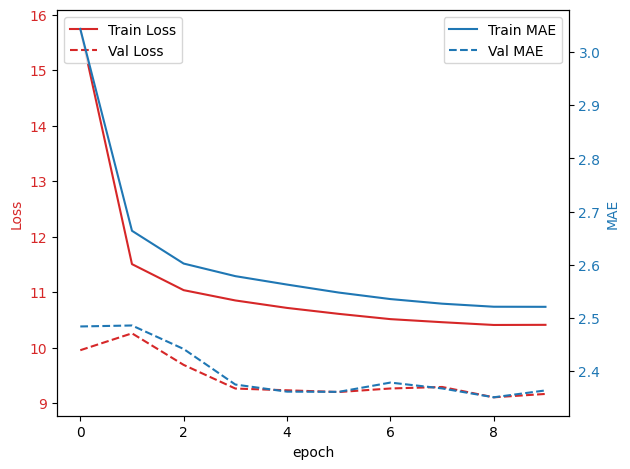

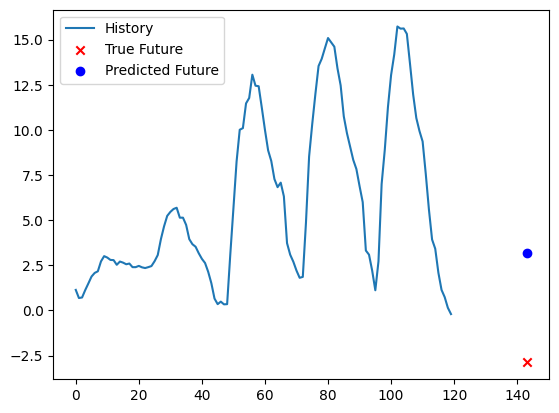

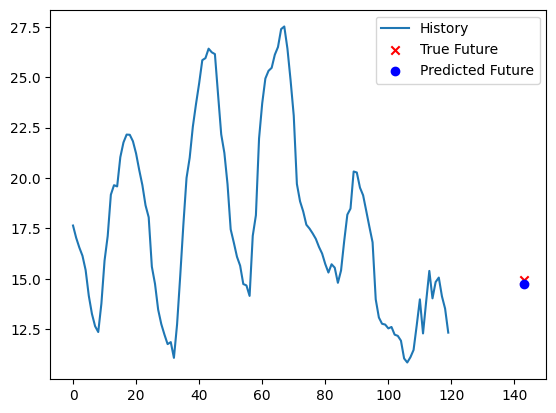

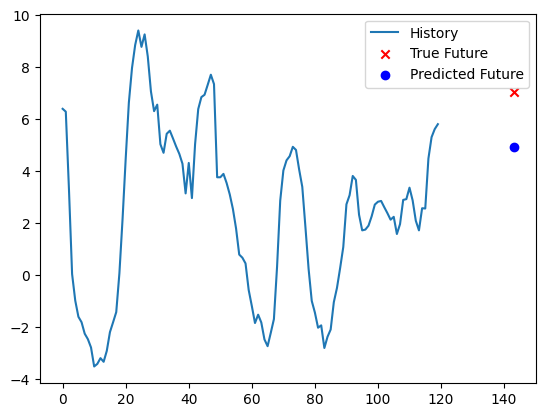

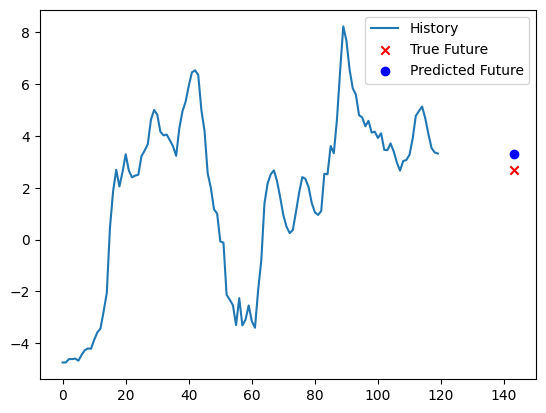

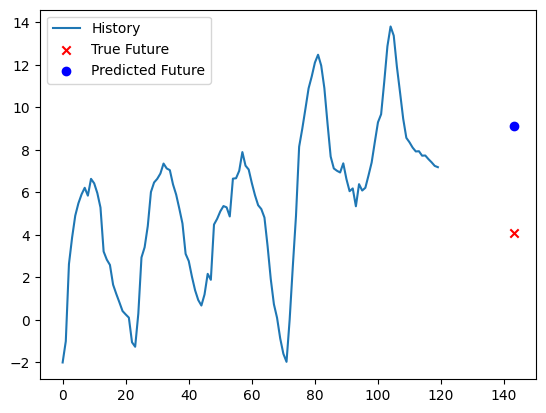

In [9]:
# ======= 方法4：用RNN预测 =========
import torch
import torch.nn as nn
import torch.optim as optim

# 定义RNN模型
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,dropout_prob=0.5):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, 
                          batch_first=True  ,nonlinearity='relu') # batch_size在第1维，即[batch, seq, feature]
        
        self.fc = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        # hn：最后一个时间步的隐藏状态
        _, hn = self.rnn(x)
        # 仅返回最后一层的隐藏状态！
        out = self.fc(hn[-1])
        return out

# 超参数
input_size =selected_features # 特征数=7
hidden_size = 16
output_size = 1

# 创建模型
model = RNNModel(input_size, hidden_size, output_size)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001) 

best_model_path = "rnn_model.pth"

# 训练模型
train_loss_arr, train_mae_arr, val_loss_arr, val_mae_arr = train_model(
    model, train_loader, val_loader, criterion, optimizer, 10, best_model_path )

# 绘制曲线
plot_loss(train_loss_arr, val_loss_arr, train_mae_arr, val_mae_arr)
model.load_state_dict(torch.load(best_model_path, weights_only=True))
plot_results(model, test_loader)

In [12]:
# 显示模型结构

from torchinfo import summary
summary(model, input_size=(batch_size, sequence_length, raw_data.shape[-1]))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

 10%|█         | 1/10 [00:04<00:37,  4.22s/it]

Epoch 1/10, Train Loss: 43.9687, Train MAE: 4.8643, Val Loss: 15.9316, Val MAE: 2.9542


 20%|██        | 2/10 [00:08<00:33,  4.21s/it]

Epoch 2/10, Train Loss: 12.3430, Train MAE: 2.7017, Val Loss: 9.8285, Val MAE: 2.4297


 30%|███       | 3/10 [00:12<00:29,  4.20s/it]

Epoch 3/10, Train Loss: 10.3241, Train MAE: 2.5073, Val Loss: 9.5060, Val MAE: 2.3982


 40%|████      | 4/10 [00:16<00:25,  4.21s/it]

Epoch 4/10, Train Loss: 9.8972, Train MAE: 2.4519, Val Loss: 9.5933, Val MAE: 2.4112


 50%|█████     | 5/10 [00:21<00:21,  4.22s/it]

Epoch 5/10, Train Loss: 9.6387, Train MAE: 2.4161, Val Loss: 9.3262, Val MAE: 2.3719


 60%|██████    | 6/10 [00:25<00:16,  4.21s/it]

Epoch 6/10, Train Loss: 9.2608, Train MAE: 2.3657, Val Loss: 9.1519, Val MAE: 2.3544


 70%|███████   | 7/10 [00:29<00:12,  4.22s/it]

Epoch 7/10, Train Loss: 8.8987, Train MAE: 2.3203, Val Loss: 9.2547, Val MAE: 2.3610


 80%|████████  | 8/10 [00:33<00:08,  4.20s/it]

Epoch 8/10, Train Loss: 8.6309, Train MAE: 2.2876, Val Loss: 9.1010, Val MAE: 2.3467


 90%|█████████ | 9/10 [00:38<00:04,  4.25s/it]

Epoch 9/10, Train Loss: 8.3861, Train MAE: 2.2527, Val Loss: 9.4121, Val MAE: 2.3726


100%|██████████| 10/10 [00:42<00:00,  4.23s/it]

Epoch 10/10, Train Loss: 8.1355, Train MAE: 2.2204, Val Loss: 9.7941, Val MAE: 2.4275
Best Val MAE: 2.3467489749777553


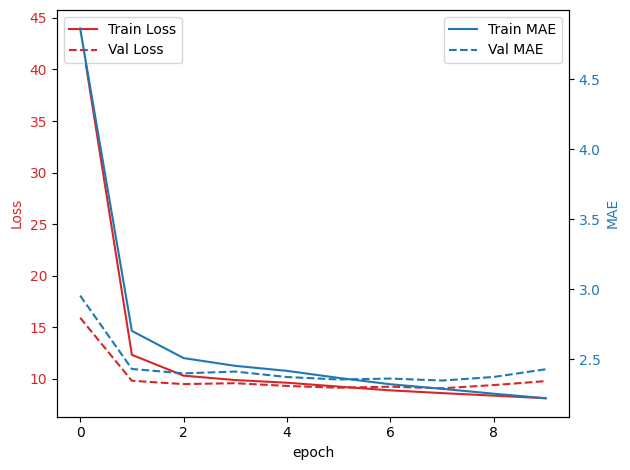

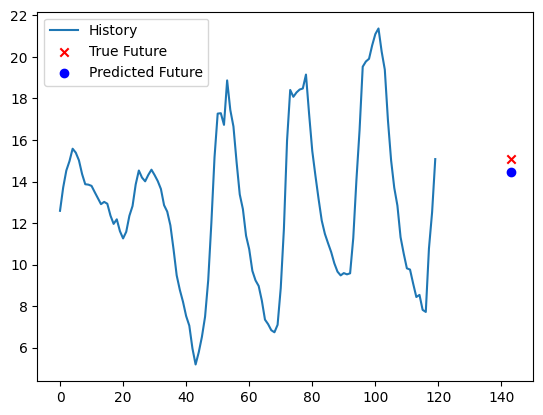

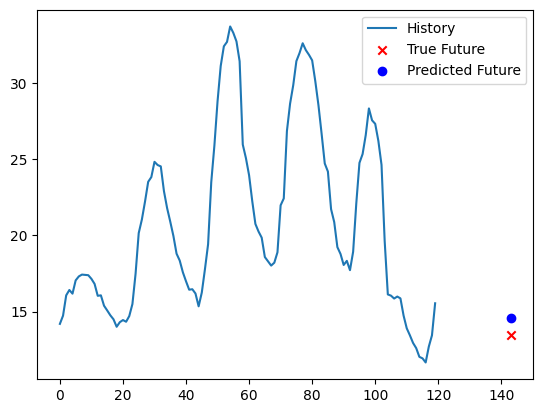

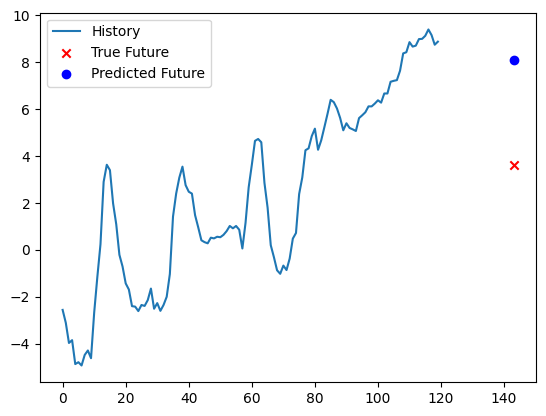

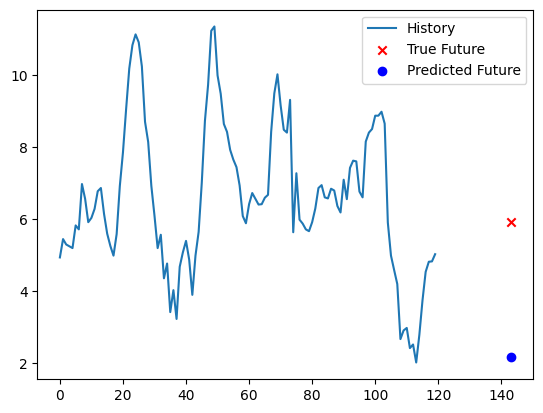

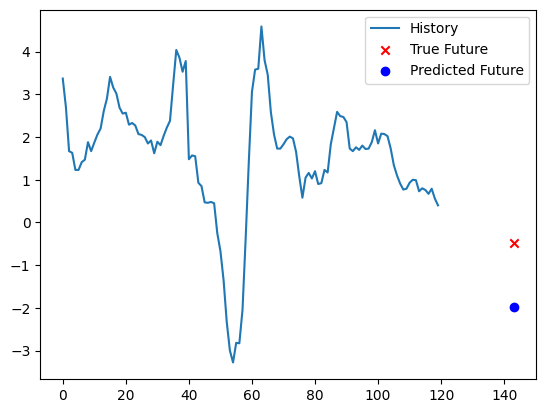

In [148]:
# ======= 方法5：用LSTM预测 =========
import torch
import torch.nn as nn
import torch.optim as optim

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        # 只要最后一层的隐藏状态
        out = self.fc(hn[-1])
        return out

# 超参数
input_size = raw_data.shape[-1] # 特征数=14
hidden_size = 16
output_size = 1

# 模型
model = LSTMModel(input_size, hidden_size, output_size)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
best_model_path = "lstm_model.pth"

# 训练模型
train_loss_arr, train_mae_arr, val_loss_arr, val_mae_arr = train_model(
    model, train_loader, val_loader, criterion, optimizer, 10, best_model_path)
# 绘图
plot_loss(train_loss_arr, val_loss_arr, train_mae_arr, val_mae_arr)
model.load_state_dict(torch.load(best_model_path, weights_only=True))
plot_results(model, test_loader)

 10%|█         | 1/10 [00:04<00:37,  4.22s/it]

Epoch 1/10, Train Loss: 47.2433, Train MAE: 5.1295, Val Loss: 16.4684, Val MAE: 3.0082


 20%|██        | 2/10 [00:08<00:33,  4.20s/it]

Epoch 2/10, Train Loss: 20.4240, Train MAE: 3.4543, Val Loss: 10.1437, Val MAE: 2.4627


 30%|███       | 3/10 [00:12<00:29,  4.23s/it]

Epoch 3/10, Train Loss: 17.9348, Train MAE: 3.2526, Val Loss: 9.5298, Val MAE: 2.4022


 40%|████      | 4/10 [00:16<00:25,  4.23s/it]

Epoch 4/10, Train Loss: 16.9521, Train MAE: 3.1648, Val Loss: 9.4821, Val MAE: 2.3941


 50%|█████     | 5/10 [00:21<00:21,  4.21s/it]

Epoch 5/10, Train Loss: 16.4121, Train MAE: 3.1098, Val Loss: 8.9610, Val MAE: 2.3286


 60%|██████    | 6/10 [00:25<00:16,  4.23s/it]

Epoch 6/10, Train Loss: 15.9627, Train MAE: 3.0693, Val Loss: 9.1454, Val MAE: 2.3491


 70%|███████   | 7/10 [00:29<00:12,  4.22s/it]

Epoch 7/10, Train Loss: 15.4856, Train MAE: 3.0216, Val Loss: 8.8772, Val MAE: 2.3151


 80%|████████  | 8/10 [00:33<00:08,  4.23s/it]

Epoch 8/10, Train Loss: 15.0924, Train MAE: 2.9905, Val Loss: 9.0032, Val MAE: 2.3257


 90%|█████████ | 9/10 [00:38<00:04,  4.24s/it]

Epoch 9/10, Train Loss: 14.7854, Train MAE: 2.9628, Val Loss: 9.0660, Val MAE: 2.3337


100%|██████████| 10/10 [00:42<00:00,  4.22s/it]

Epoch 10/10, Train Loss: 14.4661, Train MAE: 2.9325, Val Loss: 8.9863, Val MAE: 2.3213
Best Val MAE: 2.3150743503196565


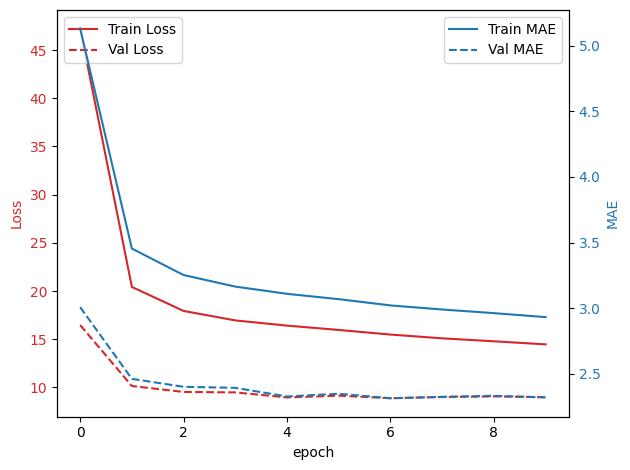

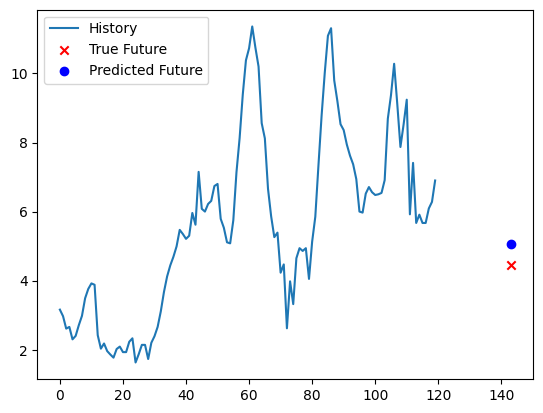

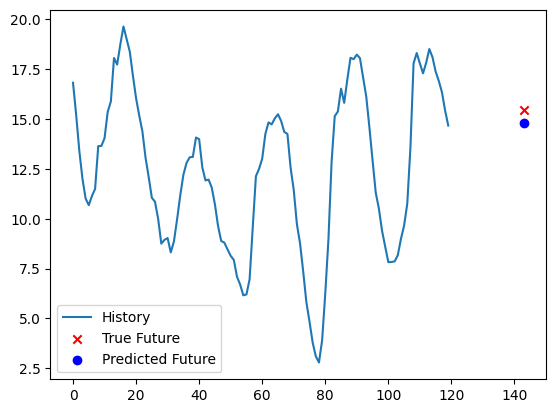

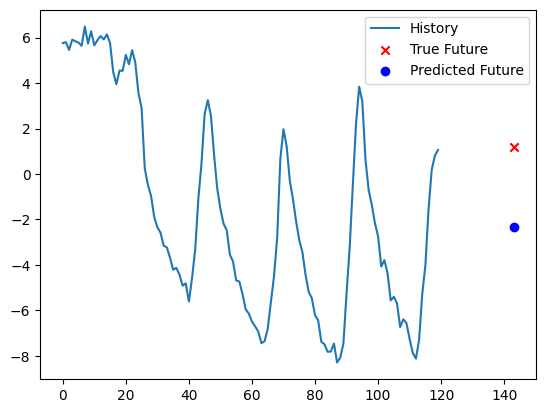

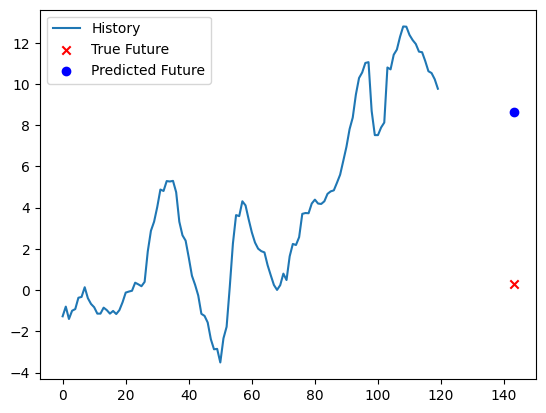

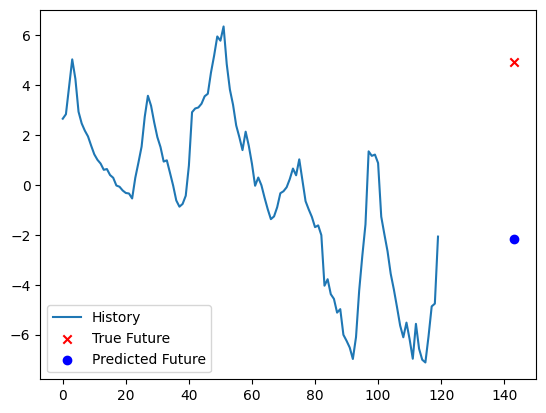

In [149]:
# ======= 方法6：用 LSTM + dropout 预测 =========
import torch
import torch.nn as nn
import torch.optim as optim

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        # dropout层
        self.dropout = nn.Dropout(0.5)
        # 全连接层        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        # dropout层
        hn2 = self.dropout(hn[-1])
        # 全连接层
        out = self.fc(hn2)
        # # 只要最后一层的隐藏状态
        # out = self.fc(hn[-1])
        return out

# 超参数
input_size = raw_data.shape[-1]
hidden_size = 16
output_size = 1

# 模型
model = LSTMModel(input_size, hidden_size, output_size)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
best_model_path = "lstm+_model.pth"

# 训练模型
train_loss_arr, train_mae_arr, val_loss_arr, val_mae_arr = train_model(
    model, train_loader, val_loader, criterion, optimizer, 10, best_model_path)
# 绘图
plot_loss(train_loss_arr, val_loss_arr, train_mae_arr, val_mae_arr)
model.load_state_dict(torch.load(best_model_path, weights_only=True))
plot_results(model, test_loader)

 10%|█         | 1/10 [00:04<00:36,  4.06s/it]

Epoch 1/10, Train Loss: 44.5236, Train MAE: 4.8751, Val Loss: 16.6244, Val MAE: 3.0085


 20%|██        | 2/10 [00:08<00:32,  4.08s/it]

Epoch 2/10, Train Loss: 12.0028, Train MAE: 2.6593, Val Loss: 9.8751, Val MAE: 2.4155


 30%|███       | 3/10 [00:12<00:28,  4.08s/it]

Epoch 3/10, Train Loss: 9.6166, Train MAE: 2.4246, Val Loss: 9.6634, Val MAE: 2.3933


 40%|████      | 4/10 [00:16<00:24,  4.10s/it]

Epoch 4/10, Train Loss: 9.1236, Train MAE: 2.3591, Val Loss: 9.4716, Val MAE: 2.3745


 50%|█████     | 5/10 [00:20<00:20,  4.11s/it]

Epoch 5/10, Train Loss: 8.8862, Train MAE: 2.3262, Val Loss: 9.6535, Val MAE: 2.3857


 60%|██████    | 6/10 [00:24<00:16,  4.08s/it]

Epoch 6/10, Train Loss: 8.6915, Train MAE: 2.2993, Val Loss: 10.4517, Val MAE: 2.4582


 70%|███████   | 7/10 [00:28<00:12,  4.06s/it]

Epoch 7/10, Train Loss: 8.5125, Train MAE: 2.2766, Val Loss: 9.9189, Val MAE: 2.4060


 80%|████████  | 8/10 [00:32<00:08,  4.04s/it]

Epoch 8/10, Train Loss: 8.3647, Train MAE: 2.2569, Val Loss: 10.3293, Val MAE: 2.4403


 90%|█████████ | 9/10 [00:36<00:04,  4.03s/it]

Epoch 9/10, Train Loss: 8.2289, Train MAE: 2.2384, Val Loss: 10.6637, Val MAE: 2.4622


100%|██████████| 10/10 [00:40<00:00,  4.07s/it]

Epoch 10/10, Train Loss: 8.1158, Train MAE: 2.2237, Val Loss: 11.4958, Val MAE: 2.5323
Best Val MAE: 2.37449859725494


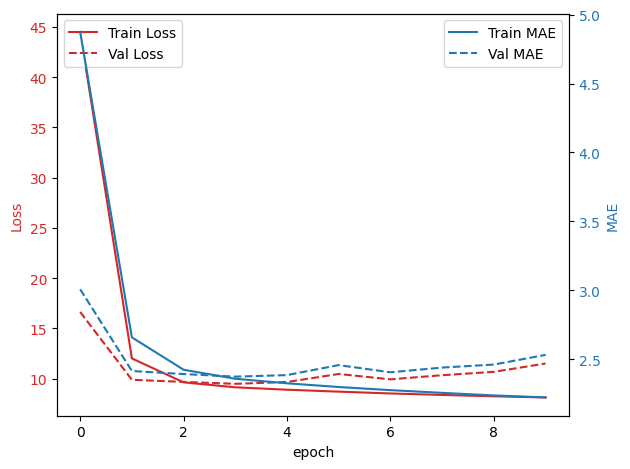

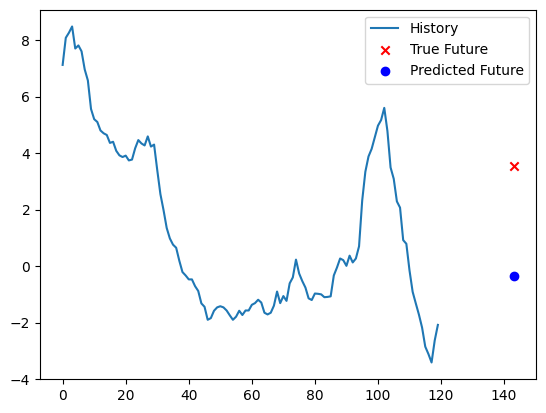

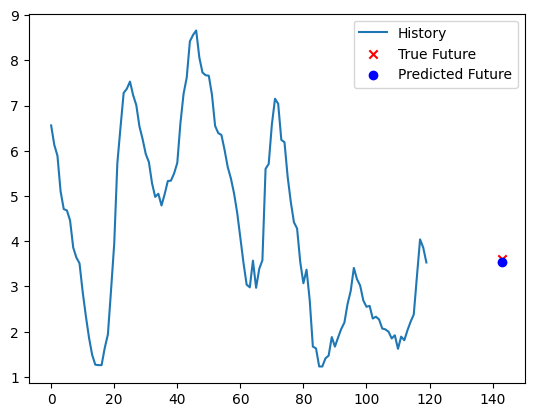

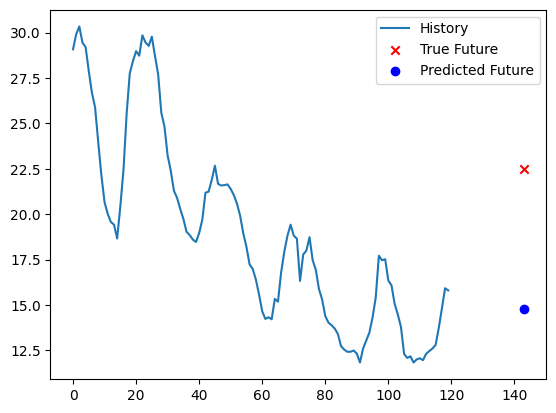

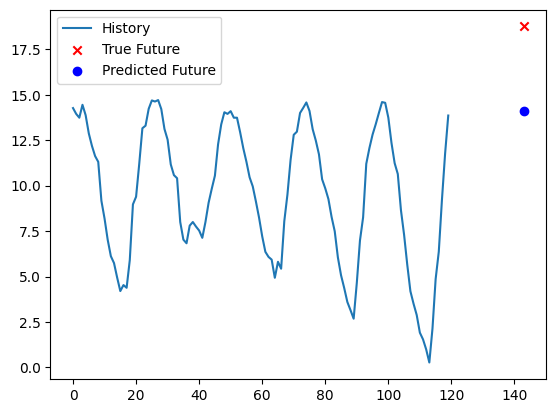

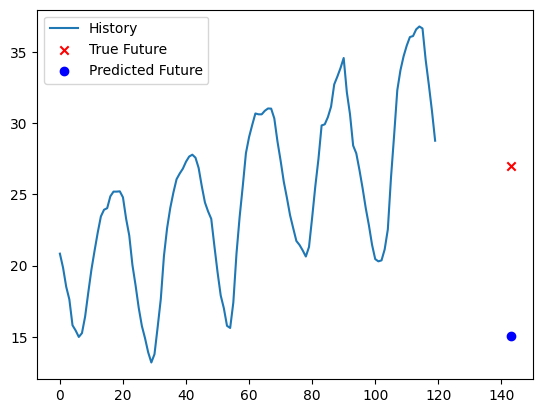

In [19]:
# ======= 方法7：用GRU预测 =========
import torch
import torch.nn as nn
import torch.optim as optim

# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, hn = self.gru(x)
        out = self.fc(hn[-1])
        return out

# 超参数
input_size = raw_data.shape[-1]
hidden_size = 16
output_size = 1

# 模型
model = GRUModel(input_size, hidden_size, output_size)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
best_model_path = "gru_model.pth"

# 训练模型
train_loss_arr, train_mae_arr, val_loss_arr, val_mae_arr = train_model(
    model, train_loader, val_loader, criterion, optimizer, 10, best_model_path )

# 绘图
plot_loss(train_loss_arr, val_loss_arr, train_mae_arr, val_mae_arr)
model.load_state_dict(torch.load(best_model_path, weights_only=True))
plot_results(model, test_loader)

In [ ]:
# ======= 方法8：用 BiLSTM + dropout 预测 =========
import torch
import torch.nn as nn
import torch.optim as optim

# 定义双向LSTM模型
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTMModel, self).__init__()
        # 双向LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)                # dropout层
        self.fc = nn.Linear(hidden_size, output_size) # 全连接层

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        hn2 = self.dropout(hn[-1])  # dropout层
        out = self.fc(hn2)          # 全连接层
        return out

# 超参数
input_size = raw_data.shape[-1]
hidden_size = 16
output_size = 1

# 模型
model = BiLSTMModel(input_size, hidden_size, output_size)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
best_model_path = "Bilstm+_model.pth"

# 训练模型
train_loss_arr, train_mae_arr, val_loss_arr, val_mae_arr = train_model(
    model, train_loader, val_loader, criterion, optimizer, 10, best_model_path)
# 绘图
plot_loss(train_loss_arr, val_loss_arr, train_mae_arr, val_mae_arr)
model.load_state_dict(torch.load(best_model_path, weights_only=True))
plot_results(model, test_loader)

 10%|█         | 1/10 [00:04<00:39,  4.44s/it]

Epoch 1/10, Train Loss: 44.4692, Train MAE: 4.8654, Val Loss: 16.4535, Val MAE: 2.9825


 20%|██        | 2/10 [00:08<00:35,  4.50s/it]

Epoch 2/10, Train Loss: 11.6095, Train MAE: 2.5993, Val Loss: 9.8685, Val MAE: 2.4396


 30%|███       | 3/10 [00:13<00:31,  4.48s/it]

Epoch 3/10, Train Loss: 9.0250, Train MAE: 2.3405, Val Loss: 9.2148, Val MAE: 2.3616


 40%|████      | 4/10 [00:17<00:27,  4.51s/it]

Epoch 4/10, Train Loss: 8.2809, Train MAE: 2.2476, Val Loss: 9.3573, Val MAE: 2.3863


 50%|█████     | 5/10 [00:22<00:22,  4.47s/it]

Epoch 5/10, Train Loss: 7.8458, Train MAE: 2.1878, Val Loss: 9.5396, Val MAE: 2.4152


 60%|██████    | 6/10 [00:26<00:17,  4.47s/it]

Epoch 6/10, Train Loss: 7.4372, Train MAE: 2.1328, Val Loss: 9.7008, Val MAE: 2.4326


 70%|███████   | 7/10 [00:31<00:13,  4.47s/it]

Epoch 7/10, Train Loss: 7.2871, Train MAE: 2.1081, Val Loss: 9.9994, Val MAE: 2.4829


 80%|████████  | 8/10 [00:35<00:08,  4.46s/it]

Epoch 8/10, Train Loss: 6.8791, Train MAE: 2.0515, Val Loss: 10.4063, Val MAE: 2.5279


 90%|█████████ | 9/10 [00:40<00:04,  4.46s/it]

Epoch 9/10, Train Loss: 6.7442, Train MAE: 2.0274, Val Loss: 10.5644, Val MAE: 2.5356


100%|██████████| 10/10 [00:44<00:00,  4.48s/it]

Epoch 10/10, Train Loss: 6.4020, Train MAE: 1.9771, Val Loss: 10.3273, Val MAE: 2.5125
Best Val MAE: 2.3615891179617714


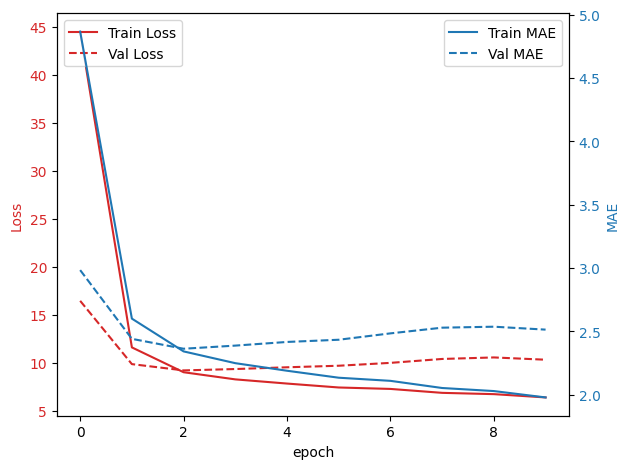

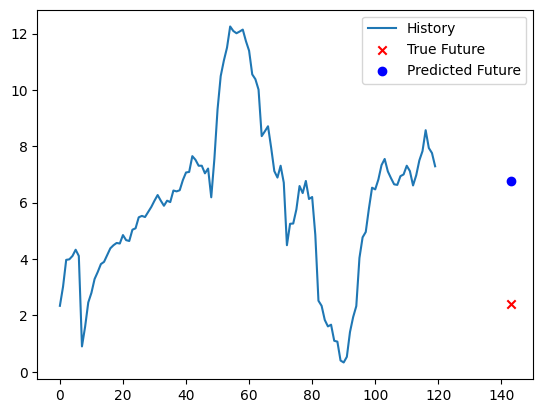

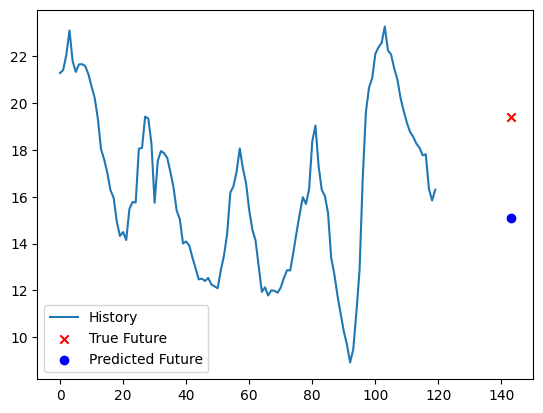

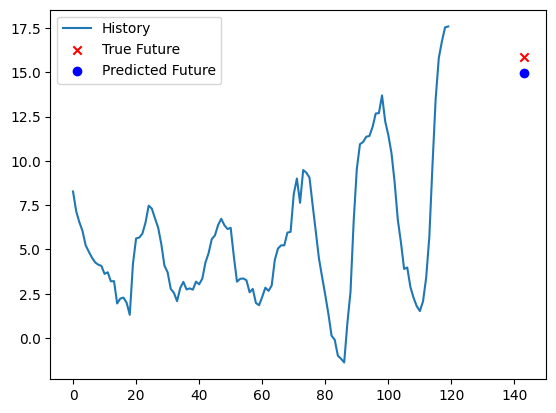

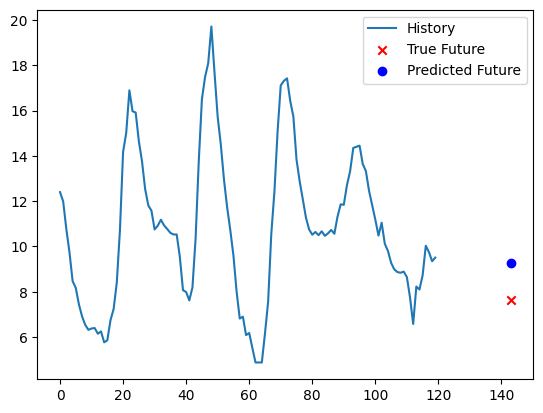

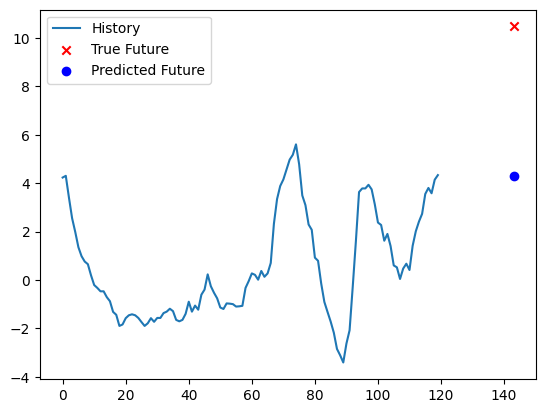

In [150]:
# ======= 方法9：用双层LSTM预测 =========
import torch
import torch.nn as nn
import torch.optim as optim

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        # 只要最后一层的隐藏状态
        out = self.fc(hn[-1])
        return out

# 超参数
input_size = raw_data.shape[-1] # 特征数=14
hidden_size = 16
num_layers = 2    # 双层LSTM
output_size = 1

# 模型
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
best_model_path = "lstm2_model.pth"

# 训练模型
train_loss_arr, train_mae_arr, val_loss_arr, val_mae_arr = train_model(
    model, train_loader, val_loader, criterion, optimizer, 10, best_model_path)
# 绘图
plot_loss(train_loss_arr, val_loss_arr, train_mae_arr, val_mae_arr)
model.load_state_dict(torch.load(best_model_path, weights_only=True))
plot_results(model, test_loader)

In [151]:

from torchinfo import summary
summary(model, input_size=(batch_size, sequence_length, raw_data.shape[-1]))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [256, 1]                  --
├─LSTM: 1-1                              [256, 120, 16]            4,224
├─Linear: 1-2                            [256, 1]                  17
Total params: 4,241
Trainable params: 4,241
Non-trainable params: 0
Total mult-adds (M): 129.77
Input size (MB): 1.72
Forward/backward pass size (MB): 3.93
Params size (MB): 0.02
Estimated Total Size (MB): 5.67

 10%|█         | 1/10 [00:05<00:45,  5.04s/it]

Epoch 1/10, Train Loss: 41.7781, Train MAE: 4.7232, Val Loss: 15.4811, Val MAE: 2.8882


 20%|██        | 2/10 [00:10<00:40,  5.07s/it]

Epoch 2/10, Train Loss: 11.2526, Train MAE: 2.5722, Val Loss: 10.0191, Val MAE: 2.4447


 30%|███       | 3/10 [00:15<00:35,  5.01s/it]

Epoch 3/10, Train Loss: 9.0058, Train MAE: 2.3427, Val Loss: 9.4200, Val MAE: 2.3738


 40%|████      | 4/10 [00:20<00:30,  5.01s/it]

Epoch 4/10, Train Loss: 8.2852, Train MAE: 2.2549, Val Loss: 9.6361, Val MAE: 2.4068


 50%|█████     | 5/10 [00:25<00:25,  5.01s/it]

Epoch 5/10, Train Loss: 7.7367, Train MAE: 2.1776, Val Loss: 10.2339, Val MAE: 2.4974


 60%|██████    | 6/10 [00:30<00:20,  5.02s/it]

Epoch 6/10, Train Loss: 7.2875, Train MAE: 2.1139, Val Loss: 9.8480, Val MAE: 2.4537


 70%|███████   | 7/10 [00:35<00:15,  5.04s/it]

Epoch 7/10, Train Loss: 6.8679, Train MAE: 2.0533, Val Loss: 11.0895, Val MAE: 2.6001


 80%|████████  | 8/10 [00:40<00:10,  5.03s/it]

Epoch 8/10, Train Loss: 6.2575, Train MAE: 1.9610, Val Loss: 10.7317, Val MAE: 2.5575


 90%|█████████ | 9/10 [00:45<00:04,  4.99s/it]

Epoch 9/10, Train Loss: 6.0062, Train MAE: 1.9182, Val Loss: 11.8140, Val MAE: 2.6726


100%|██████████| 10/10 [00:50<00:00,  5.02s/it]

Epoch 10/10, Train Loss: 5.3696, Train MAE: 1.8186, Val Loss: 11.8684, Val MAE: 2.6876
Best Val MAE: 2.3738088222110973


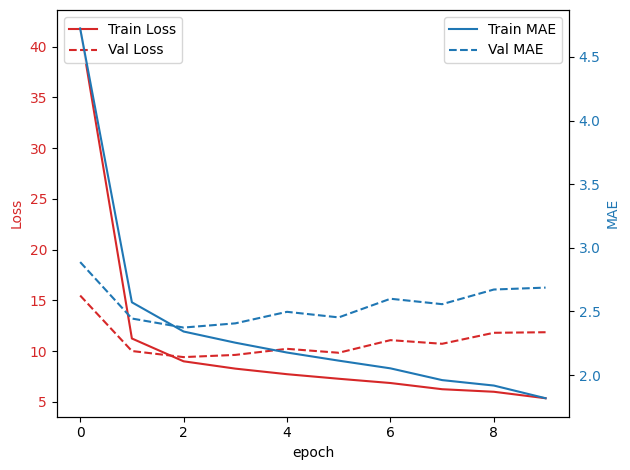

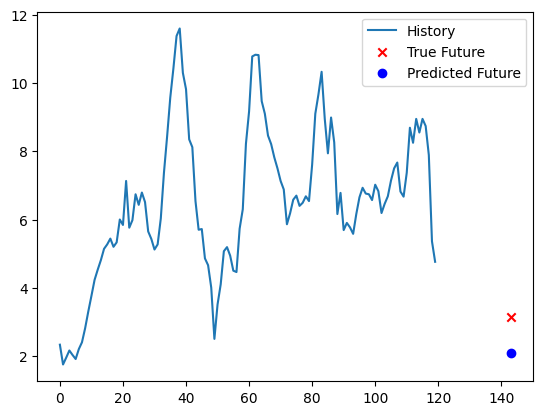

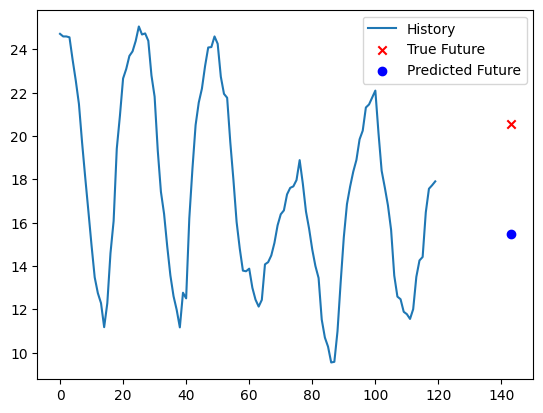

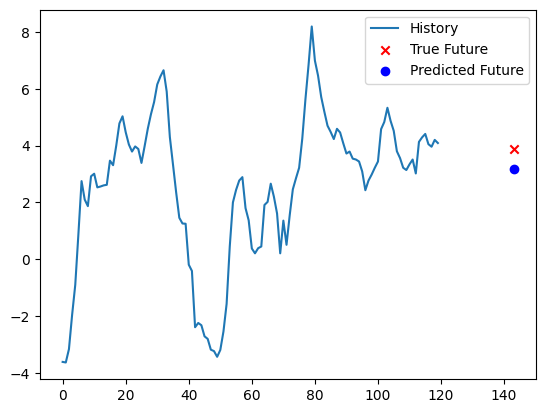

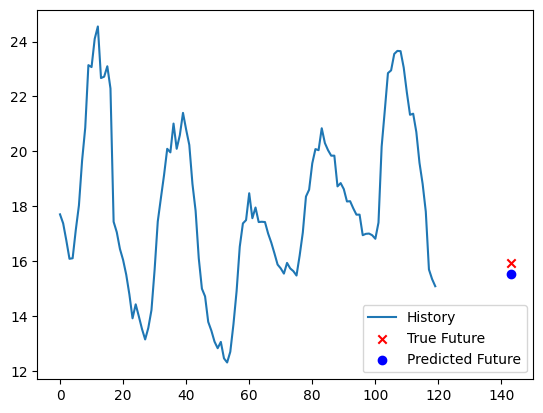

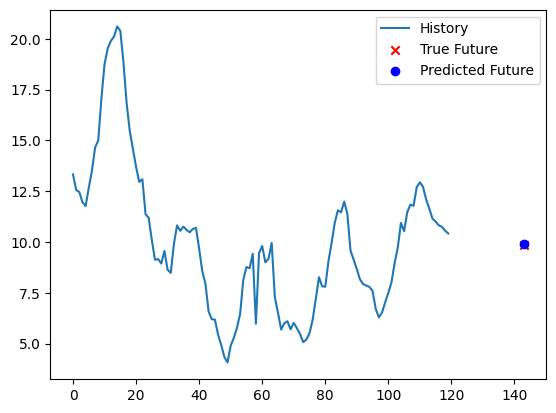

In [152]:
# ======= 方法9：用4层LSTM预测 =========
import torch
import torch.nn as nn
import torch.optim as optim

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        # 只要最后一层的隐藏状态
        out = self.fc(hn[-1])
        return out

# 超参数
input_size = raw_data.shape[-1] # 特征数=14
hidden_size = 16
num_layers = 4    # 双层LSTM
output_size = 1

# 模型
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
best_model_path = "lstm2_model.pth"

# 训练模型
train_loss_arr, train_mae_arr, val_loss_arr, val_mae_arr = train_model(
    model, train_loader, val_loader, criterion, optimizer, 10, best_model_path)
# 绘图
plot_loss(train_loss_arr, val_loss_arr, train_mae_arr, val_mae_arr)
model.load_state_dict(torch.load(best_model_path, weights_only=True))
plot_results(model, test_loader)

In [153]:
from torchinfo import summary
summary(model, input_size=(batch_size, sequence_length, raw_data.shape[-1]))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [256, 1]                  --
├─LSTM: 1-1                              [256, 120, 16]            8,576
├─Linear: 1-2                            [256, 1]                  17
Total params: 8,593
Trainable params: 8,593
Non-trainable params: 0
Total mult-adds (M): 263.46
Input size (MB): 1.72
Forward/backward pass size (MB): 3.93
Params size (MB): 0.03
Estimated Total Size (MB): 5.69